In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import copy
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import pickle

In [ ]:
transform = {
    "train": transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

In [ ]:
cifar10_train = datasets.CIFAR10(root="cifar-10-python", train=True, transform=transform["train"], download=True)
cifar10_test = datasets.CIFAR10(root="cifar-10-python", train=False, transform=transform["test"], download=True)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=128, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

cifar100_train = datasets.CIFAR100(root="cifar-100-python", train=True, transform=transform["train"], download=True)
cifar100_test = datasets.CIFAR100(root="cifar-100-python", train=False, transform=transform["test"], download=True)

cifar100_train_loader = DataLoader(cifar100_train, batch_size=128, shuffle=True)
cifar100_test_loader = DataLoader(cifar100_test, batch_size=128, shuffle=False)

dataloaders_cifar10 = {
    "train": cifar10_train_loader,
    "val": cifar10_test_loader
}

dataloaders_cifar100 = {
    "train": cifar100_train_loader,
    "val": cifar100_test_loader
}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Class Index: 0, Class Label: apple
Class Index: 1, Class Label: aquarium_fish
Class Index: 2, Class Label: baby
Class Index: 3, Class Label: bear
Class Index: 4, Class Label: beaver
Class Index: 5, Class Label: bed
Class Index: 6, Class Label: bee
Class Index: 7, Class Label: beetle
Class Index: 8, Class Label: bicycle
Class Index: 9, Class Label: bottle
Class Index: 10, Class Label: bowl
Class Index: 11, Class Label: boy
Class Index: 12, Class Label: bridge
Class Index: 13, Class Label: bus
Class Index: 14, Class Label: butterfly
Class Index: 15, Class Label: camel
Class Index: 16, Class Label: can
Class Index: 17, Class Label: castle
Class Index: 18, Class Label: caterpillar
Class Index: 19, Class Label: cattle
Class Index: 20, Class Label: chair
Class Index: 21, Class Label: chimpanzee
Class Index: 22, Class Label: clock
Class Index:

In [ ]:
class_labels = cifar100_train.classes
for idx, label in enumerate(class_labels):
    print(f"Class Index: {idx}, Class Label: {label}")

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_finetune=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print("New Model")
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
#CIFAR100 RESNET50 50
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 100) 
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

resnet50_CIFAR100_50, history_resnet50_CIFAR100_50  = train_model(resnet50, dataloaders_cifar100, criterion, optimizer, num_epochs=50)

with open('history_resnet50_CIFAR100_50','wb') as file:
    pickle.dump( history_resnet50_CIFAR100_50, file)
torch.save(resnet50_CIFAR100_50, "resnet50_CIFAR100_50.pth")

In [ ]:
#CIFAR100 RESNET18 50
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100) 
resnet18 = resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet18_CIFAR100_50, history_resnet18_CIFAR100_50 = train_model(resnet18, dataloaders_cifar100, criterion, optimizer, num_epochs=50)

with open('history_resnet18_CIFAR100_50','wb') as file:
    pickle.dump(history_resnet18_CIFAR100_50, file)
torch.save(resnet18_CIFAR100_50, "resnet18_CIFAR100_50")

In [ ]:
# CIFAR10 RESNET50 50 & CIFAR100 SHRINKED RESNET50 4
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10) 
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

resnet50_CIFAR10_50 , history_resnet50_CIFAR10_50  = train_model(resnet50, dataloaders_cifar10, criterion, optimizer, num_epochs=50)

with open('history_resnet50_CIFAR10_50','wb') as file:
    pickle.dump(history_resnet50_CIFAR10_50, file)
torch.save(resnet50_CIFAR10_50 , "resnet50_CIFAR10_50.pth")

def shrink_to_resnet18(resnet50, num_classes=100):
    resnet50_mod = models.resnet50(pretrained=False)
    resnet50_mod.layer1 = nn.Sequential(*list(resnet50_mod.layer1.children())[:2])
    resnet50_mod.layer2 = nn.Sequential(*list(resnet50_mod.layer2.children())[:1])  
    resnet50_mod.layer3 = nn.Sequential(*list(resnet50_mod.layer3.children())[:1]) 
    resnet50_mod.layer4 = nn.Sequential(*list(resnet50_mod.layer4.children())[:1])

    resnet50_mod.fc = nn.Linear(resnet50_mod.fc.in_features, num_classes) 

    resnet50_mod.conv1.load_state_dict(resnet50.conv1.state_dict())
    resnet50_mod.bn1.load_state_dict(resnet50.bn1.state_dict())      # Copy weights for BatchNorm2d
    resnet50_mod.relu.load_state_dict(resnet50.relu.state_dict())     # Copy weights for ReLU (although it's just a function)
    resnet50_mod.maxpool.load_state_dict(resnet50.maxpool.state_dict())  # Copy weights for MaxPool2d  

    resnet50_mod.layer1[0].load_state_dict(resnet50.layer1[0].state_dict())
    resnet50_mod.layer1[1].load_state_dict(resnet50.layer1[1].state_dict())
    resnet50_mod.layer2[0].load_state_dict(resnet50.layer2[0].state_dict())
    resnet50_mod.layer3[0].load_state_dict(resnet50.layer3[0].state_dict())
    resnet50_mod.layer4[0].load_state_dict(resnet50.layer4[0].state_dict())
    return resnet50_mod.to(device)


resnet50_shrinked = shrink_to_resnet18(resnet50_CIFAR10_50)
optimizer = optim.SGD(resnet50_shrinked.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet50_shrinked_CIFAR100_4, history_resnet50_shrinked_CIFAR100_4  = train_model(resnet50_shrinked, dataloaders_cifar100, criterion, optimizer, num_epochs=4)

with open('history_resnet50_shrinked_CIFAR100_4','wb') as file:
    pickle.dump(history_resnet50_shrinked_CIFAR100_4, file)
torch.save(resnet50_shrinked_CIFAR100_4, "resnet50_shrinked_CIFAR100_4.pth")



In [ ]:
#CIFAR10 RESNET50 50 & CIFAR100 SHRINKED RESNET50 50
resnet50_shrinked = shrink_to_resnet18(resnet50_CIFAR10_50)
optimizer = optim.SGD(resnet50_shrinked.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet50_shrinked_CIFAR100_50, history_resnet50_shrinked_CIFAR100_50  = train_model(resnet50_shrinked, dataloaders_cifar100, criterion, optimizer, num_epochs=50)

with open('history_resnet50_shrinked_CIFAR100_50','wb') as file:
    pickle.dump(history_resnet50_shrinked_CIFAR100_50, file)
torch.save(resnet50_shrinked_CIFAR100_50, "resnet50_shrinked_CIFAR100_50.pth")

In [ ]:
#CIFAR10 RESNET50 50 & CIFAR100 SHRINKED & FROZEN RESNET50 4
resnet50_shrinked_frozen = shrink_to_resnet18(resnet50_CIFAR10_50)
for param in resnet50_shrinked_frozen.layer1.parameters():
    param.requires_grad = False
for param in resnet50_shrinked_frozen.layer2.parameters():
    param.requires_grad = False

optimizer = optim.SGD(resnet50_shrinked_frozen.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet50_shrinked_frozen, history_resnet50_shrinked_frozen_CIFAR100_2_1  = train_model(resnet50_shrinked_frozen, dataloaders_cifar100, criterion, optimizer, num_epochs=2)

for param in resnet50_shrinked_frozen.layer1.parameters():
    param.requires_grad = True
for param in resnet50_shrinked_frozen.layer2.parameters():
    param.requires_grad = True

optimizer = optim.SGD(resnet50_shrinked_frozen.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet50_shrinked_frozen, history_resnet50_shrinked_frozen_CIFAR100_2_2  = train_model(resnet50_shrinked_frozen, dataloaders_cifar100, criterion, optimizer, num_epochs=2)

history_resnet50_shrinked_frozen_CIFAR100_4 = (history_resnet50_shrinked_frozen_CIFAR100_2_1,history_resnet50_shrinked_frozen_CIFAR100_2_2)
resnet50_shrinked_frozen_CIFAR100_4 = resnet50_shrinked_frozen

with open('history_resnet50_shrinked_frozen_CIFAR100_4','wb') as file:
    pickle.dump(history_resnet50_shrinked_frozen_CIFAR100_4, file)
torch.save(resnet50_shrinked_frozen_CIFAR100_4, "resnet50_shrinked_frozen_CIFAR100_4.pth")

In [ ]:
#CIFAR100 RESNET18 4
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)  # Adjust for CIFAR-100 classes
resnet18 = resnet18.to(device)

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
resnet18_CIFAR100_4, history_resnet18_CIFAR100_4 = train_model(resnet18, dataloaders_cifar100, criterion, optimizer, num_epochs=4)

with open('history_resnet18_CIFAR100_4','wb') as file:
    pickle.dump(history_resnet18_CIFAR100_4, file)
torch.save(resnet18_CIFAR100_4, "resnet18_CIFAR100_4.pth")

In [ ]:
with open(r'history_resnet50_CIFAR100_50', 'rb') as file:  # 'rb' means read in binary mode
    resnet50_full = pickle.load(file)

with open(r"history_resnet18_CIFAR100_50", 'rb') as file:  # 'rb' means read in binary mode
    resnet18_full = pickle.load(file)

with open(r"history_resnet50_shrinked_CIFAR100_4", 'rb') as file:  # 'rb' means read in binary mode
    finetune_history = pickle.load(file)

with open(r"history_resnet18_CIFAR100_4", 'rb') as file:  # 'rb' means read in binary mode
    fresh_history = pickle.load(file)

with open(r"history_resnet50_shrinked_CIFAR100_50", 'rb') as file:  # 'rb' means read in binary mode
    finetune_history_conv = pickle.load(file)

with open(r"history_resnet50_shrinked_frozen_CIFAR100_4", 'rb') as file:  # 'rb' means read in binary mode
    finetune_history_mod = pickle.load(file)


In [54]:
mod1 , mod2 = finetune_history_mod

In [55]:
mod1

{'train_loss': [3.2061529792785644, 2.5456535500335695],
 'train_acc': [0.23028, 0.34576],
 'val_loss': [2.593337844467163, 2.3652574462890623],
 'val_acc': [0.3312, 0.3884]}

In [56]:
mod2

{'train_loss': [2.355191353302002, 2.20107630317688],
 'train_acc': [0.3825, 0.41692],
 'val_loss': [2.218328070068359, 2.1436148914337156],
 'val_acc': [0.41550000000000004, 0.436]}

In [ ]:
mod3 = {'train_loss' : mod1['train_loss'] + mod2['train_loss'], 'train_acc' : mod1['train_acc'] + mod2['train_acc'], 'val_loss': mod1['val_loss'] + mod2['val_loss'],  'val_acc': mod1['val_acc'] + mod2[ 'val_acc']}

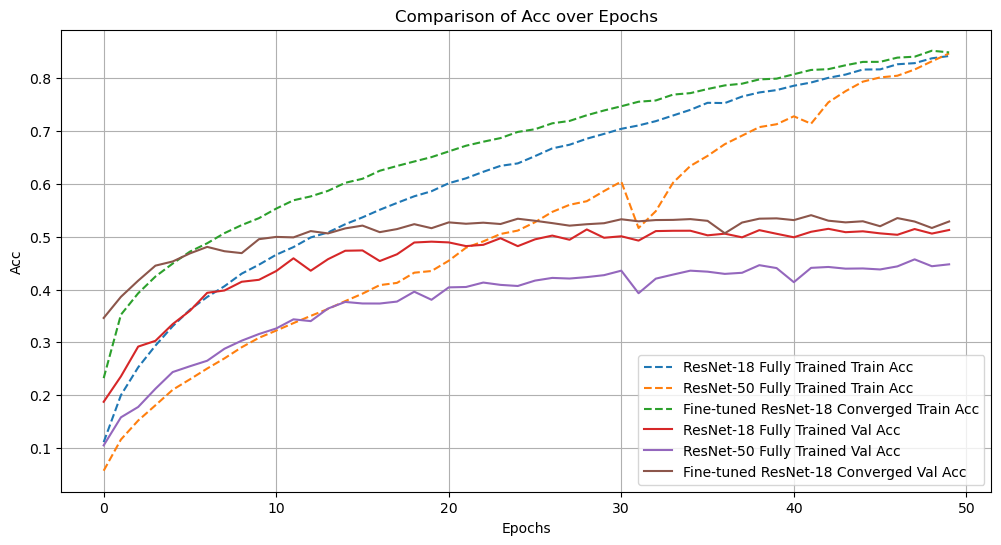

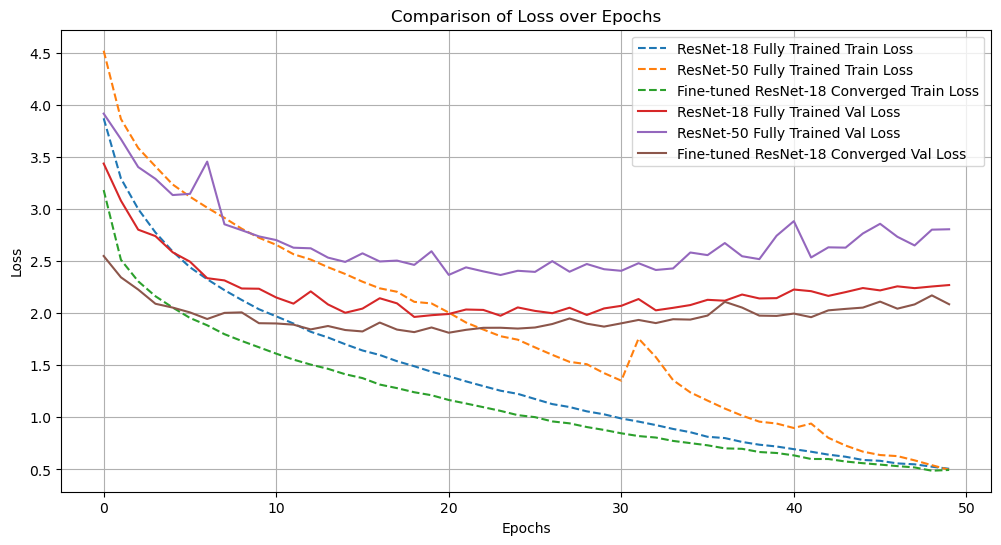

In [64]:
# Function to plot metrics
def plot_training_history(history1, history2, history3, history4, history5, history6, labels, metric):
    plt.figure(figsize=(12, 6))

    # Plot training metrics
    # plt.plot(history1[f"train_{metric}"], label=f"{labels[0]} Train {metric.capitalize()}", linestyle='--')
    # plt.plot(history2[f"train_{metric}"], label=f"{labels[1]} Train {metric.capitalize()}", linestyle='--')
    # plt.plot(history3[f"train_{metric}"], label=f"{labels[2]} Train {metric.capitalize()}", linestyle='--')
    plt.plot(history4[f"train_{metric}"], label=f"{labels[3]} Train {metric.capitalize()}", linestyle='--')
    plt.plot(history5[f"train_{metric}"], label=f"{labels[4]} Train {metric.capitalize()}", linestyle='--')
    plt.plot(history6[f"train_{metric}"], label=f"{labels[5]} Train {metric.capitalize()}", linestyle='--')


    # plt.plot(history1[f"val_{metric}"], label=f"{labels[0]} Val {metric.capitalize()}")
    # plt.plot(history2[f"val_{metric}"], label=f"{labels[1]} Val {metric.capitalize()}")
    # plt.plot(history3[f"val_{metric}"], label=f"{labels[2]} Val {metric.capitalize()}")
    plt.plot(history4[f"val_{metric}"], label=f"{labels[3]} Val {metric.capitalize()}")
    plt.plot(history5[f"val_{metric}"], label=f"{labels[4]} Val {metric.capitalize()}")
    plt.plot(history6[f"val_{metric}"], label=f"{labels[5]} Val {metric.capitalize()}")

    plt.title(f"Comparison of {metric.capitalize()} over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Accuracy
plot_training_history(finetune_history,mod3, fresh_history, resnet18_full, resnet50_full, finetune_history_conv,["Fine-tuned ResNet-18","Fine-tuned ResNet-18 Frozen Layers" ,"Fresh ResNet-18", "ResNet-18 Fully Trained", "ResNet-50 Fully Trained", "Fine-tuned ResNet-18 Converged"], "acc")

# Plot Loss
plot_training_history(finetune_history,mod3, fresh_history, resnet18_full, resnet50_full,finetune_history_conv,["Fine-tuned ResNet-18","Fine-tuned ResNet-18 Frozen Layers" , "Fresh ResNet-18", "ResNet-18 Fully Trained", "ResNet-50 Fully Trained","Fine-tuned ResNet-18 Converged"], "loss")

